In [309]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
from PIL import Image
from copy import deepcopy
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from statistics import mode
import csv
import pandas as pd

In [210]:
class_to_description = {0: "Right Scissors",
                        1: "Left Scissors",
                        2: "Right Needle driver",
                        3: "Left Needle driver",
                        4: "Right Forceps",
                        5: "Left Forceps",
                        6: "Right Empty",
                        7: "Left Empty"}

class_to_color = {0: (31,119,180),
                  1: (255,127,14),
                  2: (44,160,44),
                  3: (214,39,40),
                  4: (148,103,189),
                  5: (140,86,75),
                  6: (227,119,194),
                  7: (127,127,127)}

right_tool_to_class = {'T0': 6,
                       'T1': 2,
                       'T2': 4,
                       'T3': 0}

left_tool_to_class = {'T0': 7,
                      'T1': 3,
                      'T2': 5,
                      'T3': 1}

RIGHT = 'right'
LEFT = 'left'

CLASS = 'class'
XYXY = 'xyxy'
CONF = 'conf'

# metrics
ACCURACY = 'accuracy'
F1_MACRO = 'f1 macro'
F1 = 'f1'
RECALL = 'recall'
PRECISION = 'precision'

In [217]:
def convert_cv2_to_pil(cv_image, is_BGR=True):
    if is_BGR:
        img = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    else:
        img = cv_image
    return Image.fromarray(img)

def draw_bboxes(img, classes, bboxes):
    for cls, box in zip(classes, bboxes):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), class_to_color[cls], 2)


def draw_labels(img, classes, bboxes, confs):
    for cls, box, conf in zip(classes, bboxes, confs):
        xmin, ymin, xmax, ymax = box
        label = f"{class_to_description[cls]} {conf:.2f}"

        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)

        img = cv2.rectangle(img, (xmin - 1, ymin - 20), (xmin + w, ymin - 1), class_to_color[cls], -1)
        img = cv2.putText(img, label, (xmin, ymin - 5),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)

In [215]:
def create_bboxes_one_frame(frame, frame_predictions):
    new_img = deepcopy(frame)
    
    classes = []
    bboxes = []
    confs = []
    
    for hand in frame_predictions:
        classes.append(frame_predictions[hand][CLASS])
        confs.append(frame_predictions[hand][CONF])
        bboxes.append([round(num) for num in frame_predictions[hand][XYXY]])
    

    draw_bboxes(new_img, classes, bboxes)
    draw_labels(new_img, classes, bboxes, confs)

    return new_img

In [47]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/large_SGD/weights/best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/student/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-3-28 Python-3.8.13 torch-1.12.1 CUDA:0 (Tesla M60, 8129MiB)

Fusing layers... 
Model summary: 267 layers, 46145973 parameters, 0 gradients, 107.8 GFLOPs
Adding AutoShape... 


In [48]:
def get_number_of_frames(video_name):
    cap2 = cv2.VideoCapture(f'videos/{video_name}.wmv')
    length = int(cap2.get(cv2.CAP_PROP_FRAME_COUNT))
    return length

In [49]:
def get_raw_results(video_name):
    frames = []
    raw_results = []
    count = 0
    cap = cv2.VideoCapture(f'videos/{video_name}.wmv')
    frames_count = get_number_of_frames(video_name)
    
    while(cap.isOpened()):
        succ, frame = cap.read()
        if succ:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB
            result = model(frame_rgb)
            s = result.xyxy[0].shape[0]
            frames.append(frame_rgb)
            raw_results.append(result.xyxy[0])
           
            count += 1
            if count == frames_count:  # End of video
                break
    return frames, raw_results

In [54]:
def extract_from_result(result):
    extracted = {RIGHT: [],
                 LEFT: []}
    for pred in result:
        *xyxy, conf, cls = pred.tolist()
        cls = int(cls)
        hand = RIGHT if cls % 2 == 0 else LEFT
        extracted[hand].append({CLASS: cls, CONF: conf, XYXY: xyxy})
        
    return extracted

In [55]:
def extract_all_results(results):
    all_extracted = []
    for result in results:
        all_extracted.append(extract_from_result(result))
    return all_extracted

In [120]:
def extract_maximal_confidence(extracted_result):
    new_extracted = {}
    if len(extracted_result[RIGHT]) == 0:
        new_extracted[RIGHT] = None
    else:
        new_extracted[RIGHT] = max(extracted_result[RIGHT], key=lambda ext: ext[CONF])
        
    if len(extracted_result[LEFT]) == 0:
        new_extracted[LEFT] = None
    else:
        new_extracted[LEFT] = max(extracted_result[LEFT], key=lambda ext: ext[CONF])
    return new_extracted

In [116]:
def extract_only_classes(extracted_results):
    classes = {RIGHT: [],
               LEFT: []}
    for extracted_result in extracted_results:
#         max_conf = extract_maximal_confidence(extracted_result)
        right = extracted_result[RIGHT][CLASS] if extracted_result[RIGHT] is not None else -1
        left = extracted_result[LEFT][CLASS] if extracted_result[LEFT] is not None else -1
        classes[RIGHT].append(right)
        classes[LEFT].append(left)
    return classes

In [58]:
def create_ground_truth(video_name, hand):
    gt = []
    with open(f'HW1_dataset/tool_usage/tools_{hand}/{video_name}.txt', 'r') as file:
        for line in file:
            trimmed = line.strip()
            start, stop, tool = trimmed.split()
            start, stop = int(start), int(stop)
            for i in range(start, stop + 1):
                gt.append(right_tool_to_class[tool] if hand == RIGHT else left_tool_to_class[tool])

    return gt

In [59]:
def calculate_classes_metric_one_hand(metric, ground_truth, predictions):
    unique_gt_labels = list(sorted(set(ground_truth)))
    metric_result = metric(ground_truth, predictions, average=None, labels=unique_gt_labels)
    return dict(zip(unique_gt_labels, metric_result))

In [235]:
def calculate_metrics(ground_truth, predictions):
    metrics = {}
    metrics[ACCURACY] = accuracy_score(ground_truth, predictions)
    metrics[F1_MACRO] = f1_score(ground_truth, predictions, average='macro')
    metrics[F1] = calculate_classes_metric_one_hand(f1_score, ground_truth, predictions)
    metrics[PRECISION] = calculate_classes_metric_one_hand(precision_score, ground_truth, predictions)
    metrics[RECALL] = calculate_classes_metric_one_hand(recall_score, ground_truth, predictions)
    return metrics

In [61]:
def find_one_different(predictions, window_size=1):
    for i in range(window_size, len(predictions) - window_size):
        window = predictions[i - window_size: i] + predictions[i + 1: i + window_size + 1]
        if predictions[i] not in window:
            return i, window
    return -1, None

In [278]:
def find_label_to_replace_negative_one(predictions, idx, negative_one_window):
    window_size = negative_one_window
    window = predictions[idx - (negative_one_window // 2): idx + (negative_one_window // 2) + 1]  # window of w/2 for each side
    mode_label = mode(window)
    
    while mode_label == -1:
        window_size += 2
        window = predictions[idx - (window_size // 2): idx + (window_size // 2) + 1]  # window of w/2 for each side
        mode_label = mode(window)
    return mode_label

def fill_missing_labels_one_hand(predictions, negative_one_window=5):
    new_predictions = [pred for pred in predictions]
    if negative_one_window > 0:
        while -1 in new_predictions:
            idx = new_predictions.index(-1)
            new_predictions[idx] = find_label_to_replace_negative_one(new_predictions, idx, negative_one_window)
    return new_predictions

def fill_missing_labels(only_classes):
    right = only_classes[RIGHT]
    left = only_classes[LEFT]
    return {RIGHT: fill_missing_labels_one_hand(right),
            LEFT: fill_missing_labels_one_hand(left)}

In [219]:
def smooth_labels_one_hand(predictions, anomaly_window):
    new_predictions = [pred for pred in predictions]
    if anomaly_window > 0:
        diff_idx, window = find_one_different(new_predictions, anomaly_window)
        while diff_idx != -1:
            new_predictions[diff_idx] = mode(window)
            diff_idx, window = find_one_different(new_predictions, anomaly_window)
    return new_predictions

def smooth_labels(only_classes, anomaly_window=3):
    right = only_classes[RIGHT]
    left = only_classes[LEFT]
    return {RIGHT: smooth_labels_one_hand(right, anomaly_window=anomaly_window),
            LEFT: smooth_labels_one_hand(left, anomaly_window=anomaly_window)}

In [63]:
def predict_one_missing_bounding_box(past_bboxes):
    '''
    Predics a missing bounding box based on two previous bounding boxes and simple kinematics.
    '''
    prev_prev, prev = past_bboxes
    prev_prev, prev = np.array(prev_prev), np.array(prev)
    velocity = prev - prev_prev  # v = dr/dt
    new_box = prev + velocity  # r = r0 + v*t
    return new_box.tolist()

In [79]:
def find_index(lst, var):
    try:
        return lst.index(var)
    except ValueError:
        return -1

In [82]:
def fill_missing_bounding_boxes_one_hand(bboxes):
    idx = find_index(bboxes, None)
    while idx != -1:
        if idx <= 1:  # No past 2 frames
            bboxes[idx] = deepcopy(bboxes[1 - idx])
        else:
            bboxes[idx] = predict_one_missing_bounding_box([bboxes[idx - 2], bboxes[idx - 1]])   
        idx = find_index(bboxes, None)

In [81]:
def fill_missing_bounding_boxes(all_predictions):
    new_predictions = deepcopy(all_predictions)
    right_bboxes = [pred[RIGHT][XYXY] for pred in all_predictions]
    left_bboxes = [pred[LEFT][XYXY] for pred in all_predictions]
    fill_missing_bounding_boxes_one_hand(right_bboxes)  # Inplace
    fill_missing_bounding_boxes_one_hand(left_bboxes)   # Inplace
    for i in range(len(new_predictions)):
        new_predictions[i][RIGHT][XYXY] = right_bboxes[i]
        new_predictions[i][LEFT][XYXY] = left_bboxes[i]
    return new_predictions

In [232]:
def moving_average(bboxes, window_size) :
    bboxes_np = [np.array(bbox) for bbox in bboxes]
    ret = []
    half_window_size = window_size // 2
    for i in range(len(bboxes)):
        window = bboxes_np[max(i - half_window_size, 0): min(i + half_window_size + 1, len(bboxes_np))]
        window_actual_size = len(window)
        if window_actual_size == window_size and window_size > 3:
            weights = []
            for i in range(1, half_window_size):
                weights.insert(0, 0.7 ** i)
            for i in range(3):
                weights.append(1)
            for i in range(1, half_window_size):
                weights.append(0.7 ** i)
            total_weights = sum(weights)
            normalized_weight = [w / total_weights for w in weights]
            ret.append(np.average(window, weights=normalized_weight, axis=0).tolist())
        else:
            window_sum = np.sum(window, axis=0)
            ret.append((window_sum / window_actual_size).tolist())
    return ret

In [229]:
def smooth_bboxes(all_predictions, window_size=5):
    new_predictions = deepcopy(all_predictions)
    right_bboxes = [pred[RIGHT][XYXY] for pred in all_predictions]
    left_bboxes = [pred[LEFT][XYXY] for pred in all_predictions]
    right_smoothed = moving_average(right_bboxes, window_size=window_size)
    left_smoothed = moving_average(left_bboxes, window_size=window_size)
    for i in range(len(new_predictions)):
        new_predictions[i][RIGHT][XYXY] = right_smoothed[i]
        new_predictions[i][LEFT][XYXY] = left_smoothed[i]
    return new_predictions

In [206]:
def create_video_util(video_name, frames, final_predictions): 
    video = cv2.VideoWriter(f"{video_name}_visualized.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 30, (640, 480))
    for frame, prediction in zip(frames, final_predictions):
        new_frame = create_bboxes_one_frame(frame, prediction)
        cv_img = cv2.cvtColor(np.array(new_frame), cv2.COLOR_RGB2BGR)
        video.write(cv_img)
    cv2.destroyAllWindows()
    video.release()
    return cv_img

In [246]:
def create_metric_row(metric_val):
    row = []
    for i in range(len(class_to_description)):
        if i in metric_val:
            row.append(f"{metric_val[i]}")
        else:
            row.append(None)
    return row

def create_metrics_file(video_name, predictions_list, predictions_prefixes):
    with open(f"{video_name}_prediction_metrics.csv", 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['metric', *[class_to_description[i] for i in range(len(class_to_description))]])
        
        gt_right = create_ground_truth(video_name, RIGHT)[:len(predictions_list[0])]
        gt_left = create_ground_truth(video_name, LEFT)[:len(predictions_list[0])]
        gt_all = gt_right + gt_left
        
        for predictions, prefix in zip(predictions_list, predictions_prefixes):
            classes = extract_only_classes(predictions)
            classes_all = classes[RIGHT] + classes[LEFT]
            metrics = calculate_metrics(gt_all, classes_all)
            writer.writerow([f'{prefix}{"/" if prefix else ""}accuracy', f"{metrics[ACCURACY]}"])
            writer.writerow([f'{prefix}{"/" if prefix else ""}f1-macro', f"{metrics[F1_MACRO]}"])
            for metric_name, metric_val in metrics.items():
                if metric_name not in (ACCURACY, F1_MACRO):
                    partial_row = create_metric_row(metric_val)
                    writer.writerow([f'{prefix}{"/" if prefix else ""}{metric_name}', *partial_row])
                
            
            

In [280]:
def create_video(video_name, create_metrics=False):
    # Create raw results
    frames, raw_results = get_raw_results(video_name)
        
    # Extraction
    extracted_results = extract_all_results(raw_results)
        
    # Maximal confidence
    max_conf_predictions = deepcopy(extracted_results)
    for i in range(len(max_conf_predictions)):
        max_conf_predictions[i] = extract_maximal_confidence(max_conf_predictions[i])
                
    # Fill in missing classes
    only_classes = extract_only_classes(max_conf_predictions)
    filled_classes = fill_missing_labels(only_classes)
    filled_predictions = deepcopy(max_conf_predictions)
    for i in range(len(filled_predictions)):
        if filled_predictions[i][RIGHT] is not None:
            filled_predictions[i][RIGHT][CLASS] = filled_classes[RIGHT][i]
        else:
            filled_predictions[i][RIGHT] = {CLASS: filled_classes[RIGHT][i],
                                            CONF: filled_predictions[i - 1][RIGHT][CONF] if i > 0 else 0,
                                            XYXY: None}
        if filled_predictions[i][LEFT] is not None:
            filled_predictions[i][LEFT][CLASS] = filled_classes[LEFT][i]
        else:
            filled_predictions[i][LEFT] = {CLASS: filled_classes[LEFT][i],
                                            CONF: filled_predictions[i - 1][LEFT][CONF] if i > 0 else 0,
                                            XYXY: None}
            
    # Fill in missing bounding boxes
    filled_predictions = fill_missing_bounding_boxes(filled_predictions)
        
    # Smooth labels
    smoothed_classes = smooth_labels(filled_classes)
    smoothed_predictions = deepcopy(filled_predictions)
    for i in range(len(smoothed_predictions)):
        smoothed_predictions[i][RIGHT][CLASS] = smoothed_classes[RIGHT][i]
        smoothed_predictions[i][LEFT][CLASS] = smoothed_classes[LEFT][i]
    
    # Smooth bounding boxes
    smoothed_predictions = smooth_bboxes(smoothed_predictions)  
    
    # Video creation
    create_video_util(video_name, frames, smoothed_predictions)
        
    if create_metrics:
        create_metrics_file(video_name,
                            [max_conf_predictions, filled_predictions, smoothed_predictions],
                            ['max-conf', 'filled', 'smoothed'])

        

In [ ]:
for p in glob('videos/*'):
    name = os.path.basename(p)[:-4]
    create_video(name, create_metrics=True)

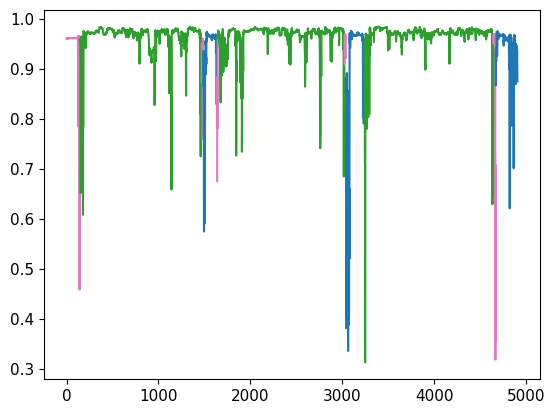

The figure above shows the confidence level of the model for the right hand predictions in one of the videos. The colors are the ground truth.

It can be seen that most of the model uncertainty is in frames where the tool changes from one to another.

# View Metrics
View the metrics of each video.

Notes:
* Empty columns means that the label does not appear in the video.
* The accuracy and f1-macro are global metrics.

In [322]:
def view_metrics(video_name):
    df = pd.read_csv(f"videos_metrics/{video_name}_prediction_metrics.csv")
    df_na = df.fillna("")
    return df, df_na

In [342]:
df1, df1_na = view_metrics('P022_balloon1')
df1_na

,metric,Right Scissors,Left Scissors,Right Needle driver,Left Needle driver,Right Forceps,Left Forceps,Right Empty,Left Empty
0,max-conf/accuracy,0.956055,,,,,,,
1,max-conf/f1-macro,0.744429,,,,,,,
2,max-conf/f1,0.773810,,0.989896,,,0.950926,0.787015,0.964928
3,max-conf/precision,0.740741,,0.986521,,,0.91897,0.858377,0.98998
4,max-conf/recall,0.809969,,0.993294,,,0.985185,0.726608,0.941113
5,filled/accuracy,0.957043,,,,,,,
6,filled/f1-macro,0.893528,,,,,,,
7,filled/f1,0.773810,,0.989976,,,0.950926,0.786392,0.966534
8,filled/precision,0.740741,,0.986523,,,0.91897,0.856897,0.990011
9,filled/recall,0.809969,,0.993454,,,0.985185,0.726608,0.944144


In [343]:
df2, df2_na = view_metrics('P023_tissue2')
df2_na

,metric,Right Scissors,Left Scissors,Right Needle driver,Left Needle driver,Right Forceps,Left Forceps,Right Empty,Left Empty
0,max-conf/accuracy,0.951522,,,,,,,
1,max-conf/f1-macro,0.597655,,,,,,,
2,max-conf/f1,0.843362,,0.985131,,,0.901074,0.490166,0.963854
3,max-conf/precision,0.813076,,0.984321,,,0.849387,0.63035,0.986154
4,max-conf/recall,0.875992,,0.985943,,,0.959459,0.40099,0.94254
5,filled/accuracy,0.952119,,,,,,,
6,filled/f1-macro,0.692623,,,,,,,
7,filled/f1,0.843362,,0.984559,,,0.900927,0.462197,0.964692
8,filled/precision,0.813076,,0.983179,,,0.849126,0.545455,0.986177
9,filled/recall,0.875992,,0.985943,,,0.959459,0.40099,0.944124


In [344]:
df3, df3_na = view_metrics('P024_balloon1')
df3_na

,metric,Right Scissors,Left Scissors,Right Needle driver,Left Needle driver,Right Forceps,Left Forceps,Right Empty,Left Empty
0,max-conf/accuracy,0.961100,,,,,,,
1,max-conf/f1-macro,0.506961,,,,,,,
2,max-conf/f1,0.862723,,0.979557,,,,0.71345,0.993
3,max-conf/precision,0.782292,,0.979091,,,,0.902748,1.0
4,max-conf/recall,0.961588,,0.980023,,,,0.589779,0.986097
5,filled/accuracy,0.965907,,,,,,,
6,filled/f1-macro,0.587036,,,,,,,
7,filled/f1,0.835556,,0.979654,,,,0.709302,0.997702
8,filled/precision,0.737978,,0.979095,,,,0.889583,1.0
9,filled/recall,0.962868,,0.980213,,,,0.589779,0.995415


In [345]:
df4, df4_na = view_metrics('P025_tissue2')
df4_na

,metric,Right Scissors,Left Scissors,Right Needle driver,Left Needle driver,Right Forceps,Left Forceps,Right Empty,Left Empty
0,max-conf/accuracy,0.942292,,,,,,,
1,max-conf/f1-macro,0.716976,,,,,,,
2,max-conf/f1,0.835314,,0.976127,,,0.903567,0.630072,0.956778
3,max-conf/precision,0.842466,,0.975176,,,0.851806,0.628571,0.983621
4,max-conf/recall,0.828283,,0.977079,,,0.962025,0.631579,0.931361
5,filled/accuracy,0.942292,,,,,,,
6,filled/f1-macro,0.860288,,,,,,,
7,filled/f1,0.835314,,0.976008,,,0.903268,0.630072,0.956778
8,filled/precision,0.842466,,0.974939,,,0.851276,0.628571,0.983621
9,filled/recall,0.828283,,0.977079,,,0.962025,0.631579,0.931361


In [346]:
df5, df5_na = view_metrics('P026_tissue1')
df5_na

,metric,Right Scissors,Left Scissors,Right Needle driver,Left Needle driver,Right Forceps,Left Forceps,Right Empty,Left Empty
0,max-conf/accuracy,0.927583,,,,,,,
1,max-conf/f1-macro,0.567978,,,,,,,
2,max-conf/f1,0.830432,,0.986249,,,0.911587,0.357895,0.88968
3,max-conf/precision,0.752336,,0.978692,,,0.94959,0.691057,0.852152
4,max-conf/recall,0.926619,,0.993923,,,0.87651,0.241477,0.930665
5,filled/accuracy,0.930169,,,,,,,
6,filled/f1-macro,0.658488,,,,,,,
7,filled/f1,0.799007,,0.986996,,,0.911654,0.359244,0.894026
8,filled/precision,0.702290,,0.978584,,,0.949596,0.689516,0.853256
9,filled/recall,0.926619,,0.995554,,,0.876628,0.242898,0.938886


### Mean Of All Results

In [356]:
mean_df = pd.concat([df1, df2, df3, df4, df5]).groupby(level=0).mean()
mean_df['metric'] = df1['metric']
mean_df = mean_df[df1.columns]
mean_df.fillna("")

,metric,Right Scissors,Left Scissors,Right Needle driver,Left Needle driver,Right Forceps,Left Forceps,Right Empty,Left Empty
0,max-conf/accuracy,0.947711,,,,,,,
1,max-conf/f1-macro,0.626800,,,,,,,
2,max-conf/f1,0.829128,,0.983392,,,0.916789,0.59572,0.953648
3,max-conf/precision,0.786182,,0.98076,,,0.892438,0.742221,0.962381
4,max-conf/recall,0.880490,,0.986052,,,0.945795,0.518087,0.946355
5,filled/accuracy,0.949506,,,,,,,
6,filled/f1-macro,0.738392,,,,,,,
7,filled/f1,0.817410,,0.983438,,,0.916694,0.589441,0.955946
8,filled/precision,0.767310,,0.980464,,,0.892242,0.722004,0.962613
9,filled/recall,0.880746,,0.986448,,,0.945824,0.518371,0.950786
